# 4. 이미지 어디까지 우려볼까?

## 7. 프로젝트: CutMix 또는 Mixup 비교실험 하기

지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았다.

이번에는 최신 기법(_CutMix_ 또는 _Mixup_)을 적용해 모델을 훈련시켜보자. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시키자. 결과를 수치화하고 비교하는 것도 잊지말자.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
import urllib3

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

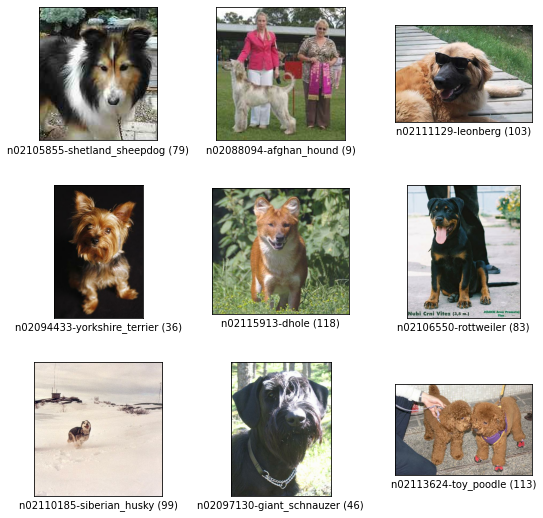

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

### 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용하자.

__아래는 *CutMix*를 적용할 수 있도록 변경한 `apply_normalize_on_dataset()`이다. `batch()` 함수 뒤에 *CutMix*가 오도록 만들어야한다. 그 이유가 뭘까?__

* CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다.

```python
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
```

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [7]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
# mix two labels
def mix_2_label(image_a, image_b,label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
def onehot(image,label):
    classes = 120
    
    onehot_label = tf.one_hot(label,classes)
    return image, onehot_label

In [13]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not with_cutmix and not with_mixup:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [16]:
num_classes = ds_info.features["label"].num_classes

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

### 2. 모델 만들기
---
앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들자. 모델은 ResNet-50을 사용한다.

#### No Augmentation

In [17]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### 기본 Augmentation

In [18]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### 기본 + CutMix 적용

In [19]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

####  기본 + Mixup 적용

In [20]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 3. 모델 훈련하기
---
모델을 훈련시키자.

힌트: 위에서 만든 *CutMix*나 *Mixup*을 사용하기 위해서는 앞에서 `resnet50`과 `aug_resnet50`을 훈련하는 데 사용했던 `sparse_categorical_crossentropy()` 대신 `categorical_crossentropy()`를 사용하자.

__`sparse_categorical_crossentropy()`를 사용하지 못하는 이유가 뭘까?__

* `cutmix()`, `mixup()`을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

#### No Augmentation, 기본 Augmentation 학습

In [22]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

tf.random.set_seed(2020)

resnet50.summary()

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 160s 166ms/step - loss: 3.1701 - accuracy: 0.2855 - val_loss: 3.1535 - val_accuracy: 0.2425
Epoch 2/20
750/750 [==============================] - 126s 169ms/step - loss: 0.9287 - accuracy: 0.7421 - val_loss: 1.1137 - val_accuracy: 0.6748
Epoch 3/20
750/750 [==============================] - 129s 173ms/step - loss: 0.3653 - accuracy: 0.9111 - val_loss: 1.0006 - val_accuracy: 0.7015
Epoch 4/20
750/750 [==============================] - 136s 181m

In [23]:
aug_resnet50.summary()

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 116s 149ms/step - loss: 3.2354 - accuracy: 0.2744 - val_loss: 3.2039 - val_accuracy: 0.2322
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 1.0651 - accuracy: 0.6935 - val_loss: 1.1882 - val_accuracy: 0.6514
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 0.5945 - accuracy: 0.8281 - val_loss: 1.0817 - val_accuracy: 0.6844
Epoch 4/20
750/750 [==============================] - 111s 14

#### 기본 + CutMix 적용, 기본 + Mixup 적용 학습

In [24]:
cutmix_resnet50.summary()

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 117s 151ms/step - loss: 2.3923 - accuracy: 0.6489 - val_loss: 1.5359 - val_accuracy: 0.6003
Epoch 2/20
750/750 [==============================] - 113s 151ms/step - loss: 2.2129 - accuracy: 0.6853 - val_loss: 1.2345 - val_accuracy: 0.6709
Epoch 3/20
750/750 [==============================] - 114s 151ms/step - loss: 2.1176 - accuracy: 0.7069 - val_loss: 1.2994 - val_accuracy: 0.6630
Epoch 4/20
750/750 [==============================] - 113s 15

In [25]:
mixup_resnet50.summary()

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = aug_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 116s 153ms/step - loss: 1.8889 - accuracy: 0.8307 - val_loss: 1.4854 - val_accuracy: 0.6695
Epoch 2/20
750/750 [==============================] - 114s 153ms/step - loss: 1.8133 - accuracy: 0.8458 - val_loss: 1.4166 - val_accuracy: 0.6770
Epoch 3/20
750/750 [==============================] - 114s 153ms/step - loss: 1.8027 - accuracy: 0.8436 - val_loss: 1.5185 - val_accuracy: 0.6440
Epoch 4/20
750/750 [==============================] - 114s 15

### 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화하자.

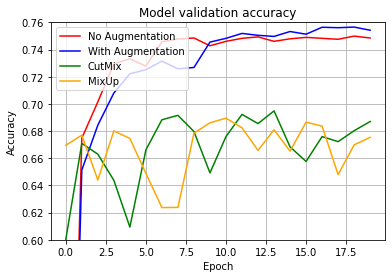

In [26]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'green')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()

### 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해보자.

#### 성능 정리

* No Augmentation과 기본 Augmentation을 비교하면 EPOCH이 진행되면서 기본 Augmentation이 조금씩 향상된 모습을 보인다.
* 기본 + CutMix 적용, 기본 + Mixup 적용은 No Augmentation보다도 성능이 더 좋지 않게 나왔다.

### 루브릭
---
* CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?<br>
(_CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다._)

    * __No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이 4가지 경우의 데이터셋에 대하여 ResNet모델을 훈련시켰다.__

* 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?<br>
( _Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함_)
    
    * __Augmentaion 적용해서 성능이 더 좋아지지는 않았다.__

* 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?<br>
(_기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다._)
    
    * __No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이 4가지 결과를 시각화하였고, 분석하였다.__

### 회고 
---
* ResNet을 직접 쌓는거보다는 시간이 덜걸렸지만, input 오류 해결, 코드 오타 등을 해결하는데 시간을 많이 썼다.
* 그렇게 열심히 했는데 성능이 생각보다 잘 나오지 않아서 실망했다.
* Augmentation의 필요성을 이론으로는 알겠는데, 실제로 경험해보지 못해서 아쉽다.